# All imports

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist
from scipy.io import wavfile
import IPython.display as ipyd
import librosa
import librosa.display
import soundfile as sf
import os
import pandas as pd
import seaborn as sns

# All functions used in the experiment

In [16]:

def remove_trailing_silence(audio_file):
    audio, sr = librosa.load(audio_file, sr= 32000, mono=True)
    clip = librosa.effects.trim(audio, top_db= 25)
    sf.write('filtered.wav', clip[0], 32000)
    
def extract_features(filepath, filter_level):
    audio, sr = librosa.load(filepath, sr= 32000, mono=True)
    clip = librosa.effects.trim(audio, top_db= 10)
    sf.write('filtered.wav', clip[0], 32000)
    f_s, signal = wavfile.read('filtered.wav')
    n_fft = int(0.025 * f_s)  # 25 ms
    hop_length = int(0.01 * f_s)  # 10 ms
    mel_spec = librosa.feature.melspectrogram(
        y=signal / 1.0, sr=f_s, n_mels=40,
        n_fft=n_fft, hop_length=hop_length
    )
    log_mel_spec = np.log(mel_spec)
    return log_mel_spec.T

def dtw(dist_mat):

    N, M = dist_mat.shape

    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],  # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return path[::-1], cost_mat

def getCost(x_seq, y_seq):
    M = y_seq.shape[0]
    N = x_seq.shape[0]
    dist_mat = dist.cdist(x_seq, y_seq, "cosine")
    path, cost_mat = dtw(dist_mat)
    cost_mat_normalized = cost_mat / (M + N)

    return path, cost_mat, cost_mat_normalized

def splitSearch(q, search, step_size):
    q_length = q
    search_length = search.shape[0]
    step_num = 0
    searches = []
    while (step_num*step_size+q_length < search_length):
        searches.append(search[step_num*step_size:step_num*step_size+q_length])
        step_num+=1
    if step_num == 0:
        searches.append(search[step_num*step_size:step_num*step_size+q_length])
    return searches
        

def getCosts(q, searches):
    costs=[]
    for i in searches:
        path, cost_mat, cost_mat_normalized = getCost(q, i)
        costs.append(cost_mat_normalized[-1, -1].tolist())
    return costs

def getScaled(num_costs, num):
    max_cost_len=max(num_costs)
    if num_costs[num] > 1:
        div=max_cost_len/float(num_costs[num]-1)
        x=[0]
        for i in range(1,num_costs[num]):
            x.append(i*div)
    else: 
        x=[max_cost_len/2]
    return x

# Load training data

In [17]:
seq = []
clusters = []
filter_level=-25
for folder in os.listdir('./training'):
    if 'wav' not in folder:
        cluster = folder
        for file in os.listdir('./training/' + folder):
            signal_seq = extract_features('./training/' + folder + '/' + file,filter_level)
            seq.append(signal_seq)
            clusters.append(cluster)
training = {'features': seq, 'labels': clusters}

# Load testing data

In [18]:
seq = []
clusters = []
tests=[]
keys=[]
filter_level=5
train=['eat', 'fetch', 'sit', 'name', 'lay']
for test in os.listdir('./testing_QBE'):
    label = test[:-4]
    label = label.replace("_", " " )
    signal_seq = extract_features('./testing_QBE/' + test,filter_level)
    seq.append(signal_seq)
    clusters.append(label)
    if label == 'name':
        tests.append('jack')
    else:
        tests.append(label)
    if train[0] in label:
        keys.append(train[0])
    elif train[1] in label:
        keys.append(train[1])
    elif train[2] in label:
        keys.append(train[2])
    elif train[3] in label:
        keys.append(train[3])
    elif 'jack' in label:
        keys.append('jack')
    elif train[4] in label:
        keys.append(train[4])
testing = {'features': seq, 'labels': clusters, 'sentence key': keys}

# Get max length of each training label

In [19]:
train=['eat', 'fetch', 'sit', 'name', 'lay']
max_len=[1000,1000,1000,1000,1000]
for seq, label in zip(training['features'],training['labels']):
    if label == train[0] and seq.shape[0]<max_len[0]:
        max_len[0] = seq.shape[0]
    elif label == train[1] and seq.shape[0]<max_len[1]:
        max_len[1] = seq.shape[0]
    elif label == train[2] and seq.shape[0]<max_len[2]:
        max_len[2] = seq.shape[0]
    elif label == train[3] and seq.shape[0]<max_len[3]:
        max_len[3] = seq.shape[0]
    elif label == train[4] and seq.shape[0]<max_len[4]:
        max_len[4] = seq.shape[0]
print(max_len)

[18, 13, 13, 18, 37]


In [20]:
raw_data={'test_label': [], 'test_seq': [], 'test_seg': [], 'train_label': [], 'train_seq': [], 'costs': [], 'scaled_axis': []}

# Preform average QBE DTW on all data items and stores all comparisons

In [21]:
test_label_data=[]
test_seq_data=[]
test_seg_data=[]
train_label_data=[]
train_seq_data=[]
costs_data=[]
scaled_axis_data=[]
test_lengths=[]
train_lengths=[]
step_size = 3
num_costs = []
abs_min=100
test_pred=[]
pred_cost=[]
pred_keys=[]
min_costs=[]
comp_keys=[]
for test_seq, test_label, key in zip(testing['features'], testing['labels'], testing['sentence key']):
    abs_min=100
    pred_temp=''
    for train_seq, train_label in zip(training['features'], training['labels']):
        for l in train:
            if l == train_label:
                train_seq_len=max_len[train.index(l)]
        test_seg = splitSearch(train_seq_len, test_seq, step_size)
        costs = getCosts(train_seq, test_seg)
        min_cost = min(costs)
        comp_keys.append(key)
        min_costs.append(min_cost)
        if min_cost < abs_min:
            abs_min = min_cost
            pred_temp = train_label
        axis = range(len(costs))
        num_costs.append(len(costs))
        test_label_data.append(test_label)
        test_seq_data.append(test_seq)
        test_seg_data.append(test_seg)
        train_label_data.append(train_label)
        train_seq_data.append(train_seq)
        costs_data.append(costs)
        scaled_axis_data.append(axis)
        test_lengths.append(test_seq.shape[0])
        train_lengths.append(train_seq.shape[0])
    if pred_temp == 'name':
        test_pred.append('jack')
    else:
        test_pred.append(pred_temp)
    pred_cost.append(abs_min)
    pred_keys.append(key)
for i in range(len(num_costs)):
    scaled_axis_data[i] = getScaled(num_costs, i)
data={'test_label': test_label_data, 'test_seq': test_seq_data, 'key': comp_keys, 'test_seg': test_seg_data, 
      'train_label': train_label_data, 'train_seq': train_seq_data, 'costs': costs_data, 'scaled_axis': scaled_axis_data}


In [22]:
data={'test_label': test_label_data, 'test_seq': test_seq_data, 'key': comp_keys, 'test_seg': test_seg_data, 
      'train_label': train_label_data, 'train_seq': train_seq_data, 'costs': costs_data, 'scaled_axis': scaled_axis_data}

all_comp_before={'test': test_label_data, 'key': comp_keys, 'train': train_label_data, 'cost': min_costs}
print(len(all_comp_before['cost']))

2500


In [23]:
train_costs=[]
test_label_avg=[]
train_label_avg=[]
axis_avg=[]
min_costs=[]
key_avg=[]
for test in tests:
    for label in train:
        costs=[]
        count=0
        for test_label, train_label, cost, axis, key in zip(data['test_label'],data['train_label'],data['costs'],data['scaled_axis'],data['key']):
            if test == test_label and label == train_label:
                axis_temp = axis
                count+=1
                if len(costs) == 0:
                    costs=[0]*len(cost)
                    for i in range(len(cost)):
                        costs[i]=costs[i]+cost[i]
                else: 
                    for i in range(len(cost)):
                        costs[i]=costs[i]+cost[i]
        for i in range(len(costs)):
            costs[i]=costs[i]/float(count)
        test_label_avg.append(test)
        train_label_avg.append(label)
        train_costs.append(costs)
        axis_avg.append(axis_temp)
        min_costs.append(min(costs))
        if train[0] in test:
            key_avg.append(train[0])
        elif train[1] in test:
            key_avg.append(train[1])
        elif train[2] in test:
            key_avg.append(train[2])
        elif train[3] in test:
            key_avg.append(train[3])
        elif 'jack' in test:
            key_avg.append('jack')
        elif train[4] in test:
            key_avg.append(train[4])
data_avg={'test': test_label_avg, 'train': train_label_avg, 'cost': train_costs, 'axis': axis_avg, 'key': key_avg}
all_comp={'test': test_label_avg, 'train': train_label_avg, 'key': key_avg, 'min': min_costs}

In [24]:
pred_temp = ''
pred_test = []
pred_train = []
pred_cost = []
pred_key=[]
for test in tests:
    min_cost = 1000
    key_temp=''
    for test_label, train_label, cost, key in zip(data_avg['test'], data_avg['train'], data_avg['cost'], data_avg['key']):
        if test_label == test:
            min_temp = min(cost)
            if min_temp < min_cost:
                min_cost = min_temp
                if train_label == 'name':
                    train_label = 'jack'
                pred_temp = train_label
                key_temp=key
    pred_test.append(test)
    pred_train.append(pred_temp)
    pred_key.append(key_temp)
    pred_cost.append(min_cost)
all_pred = {'test': pred_test, 'pred': pred_train, 'key': pred_key, 'cost': pred_cost}
correct=0
for test, test_pred in zip(all_pred['test'], all_pred['pred']):
    if test_pred in test:
        correct+=1
        
accuracy=float(correct/len(all_pred['test']))*100.0
print('Accuracy:'+str(accuracy))

Accuracy:80.0


C:\Users\Hanz\AppData\Local\Temp\ipykernel_10148\400270868.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
C:\Users\Hanz\AppData\Local\Temp\ipykernel_10148\400270868.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure(num)


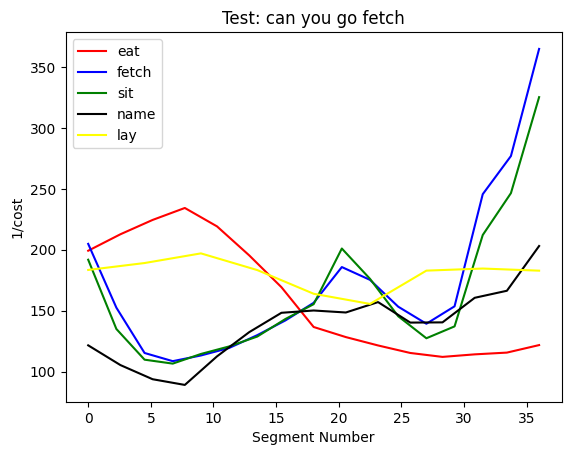

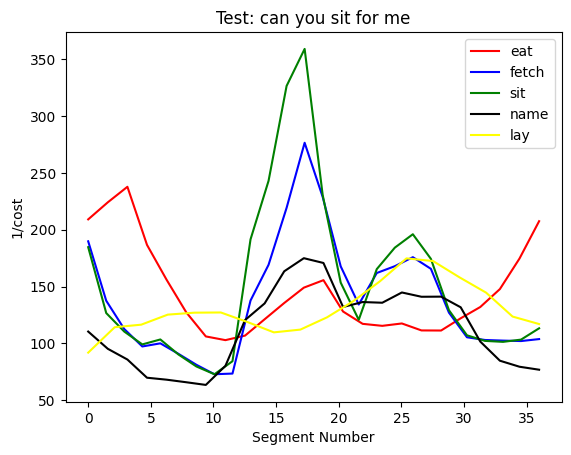

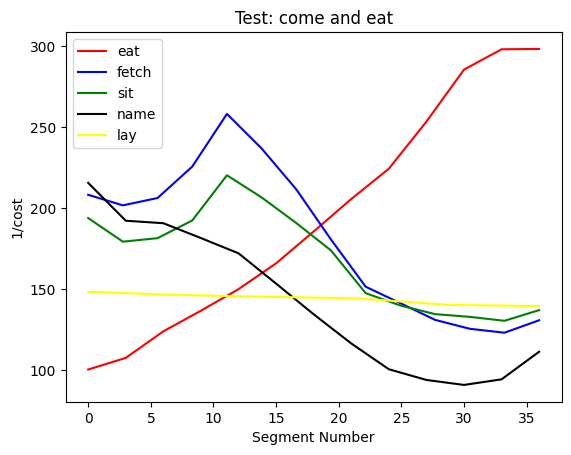

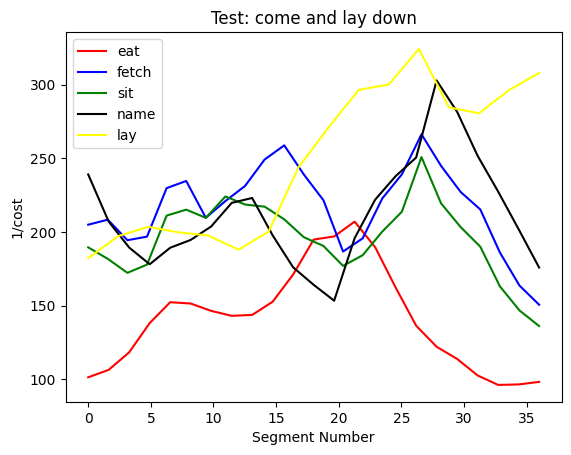

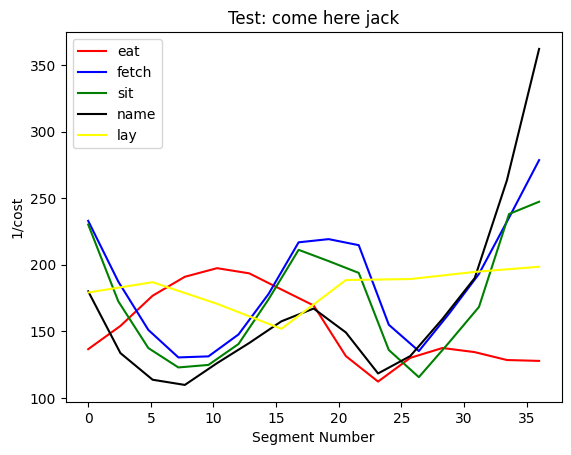

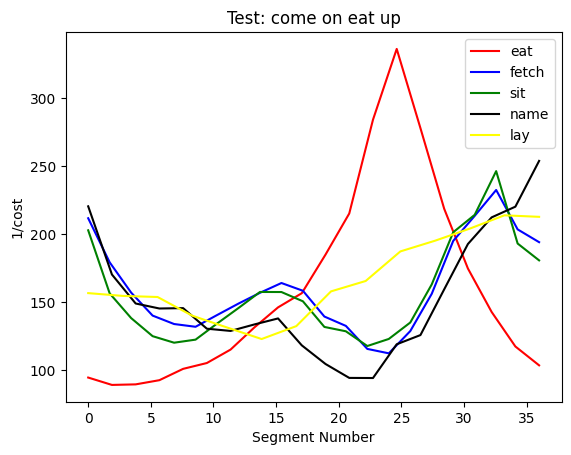

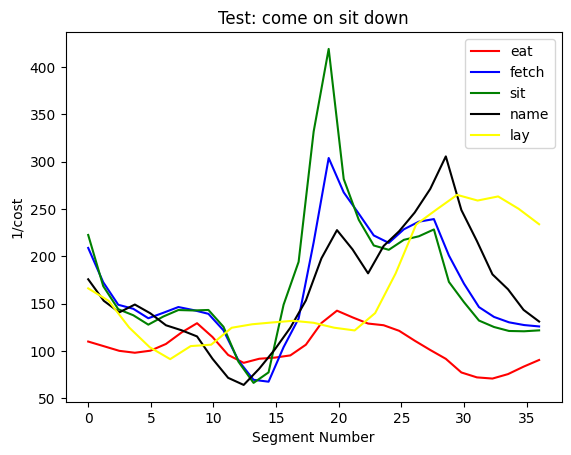

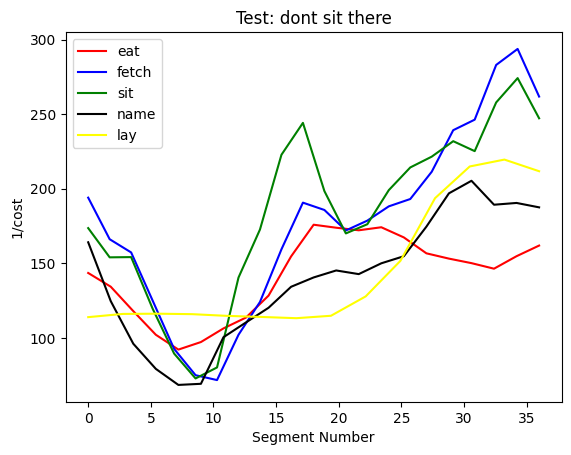

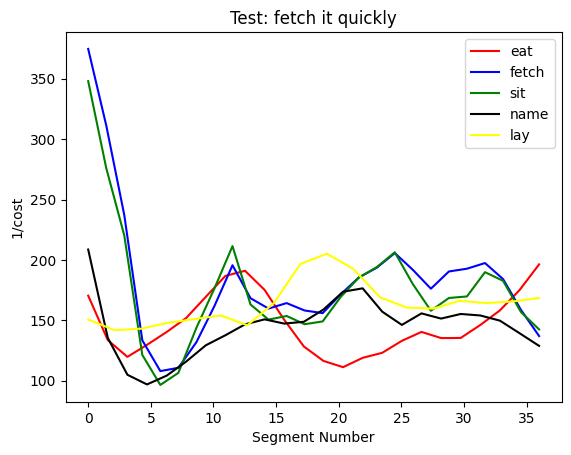

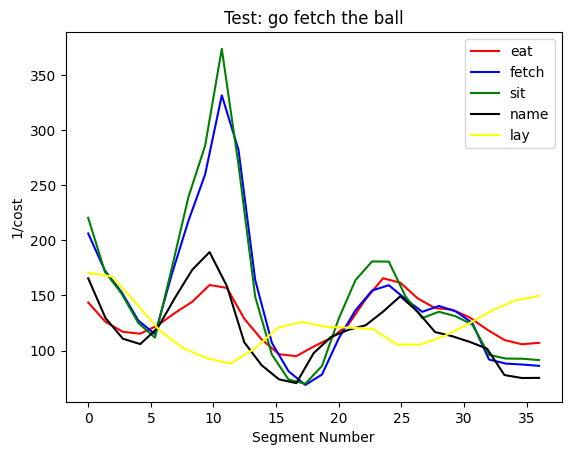

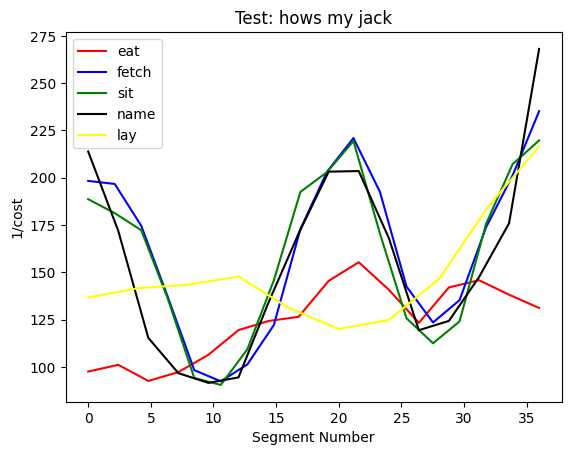

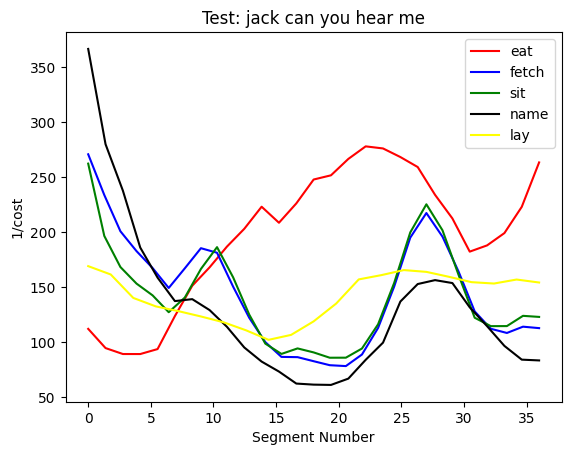

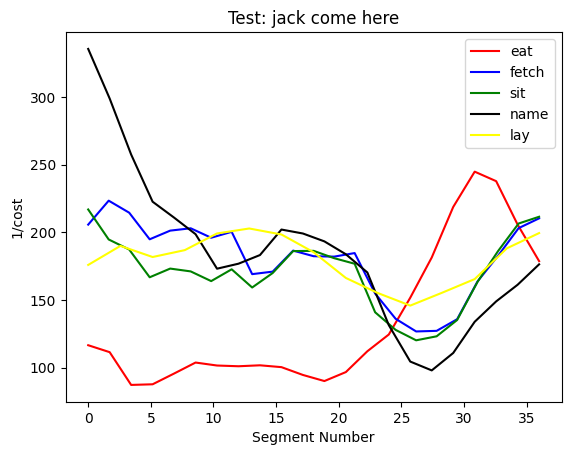

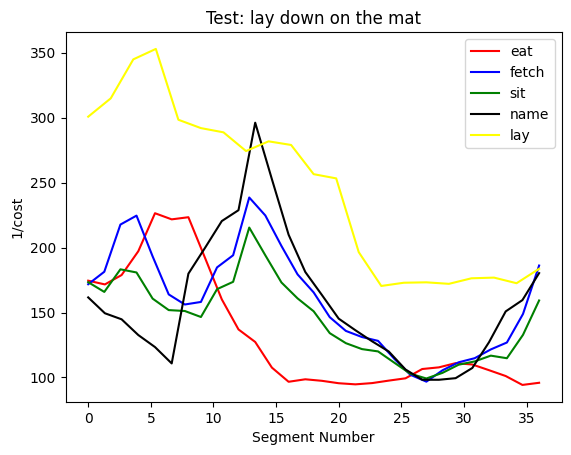

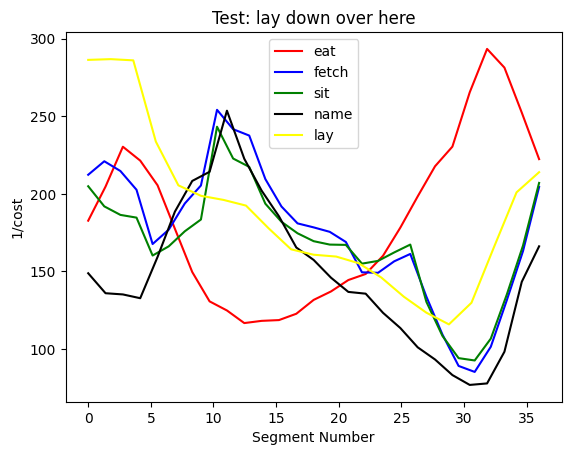

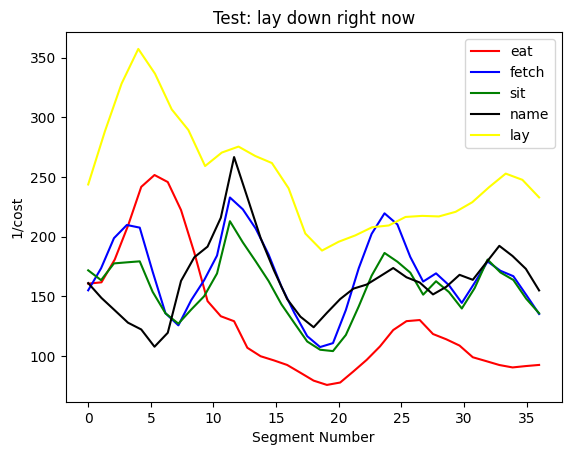

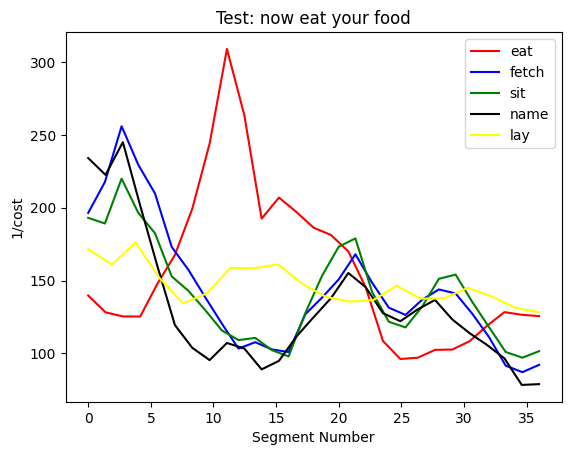

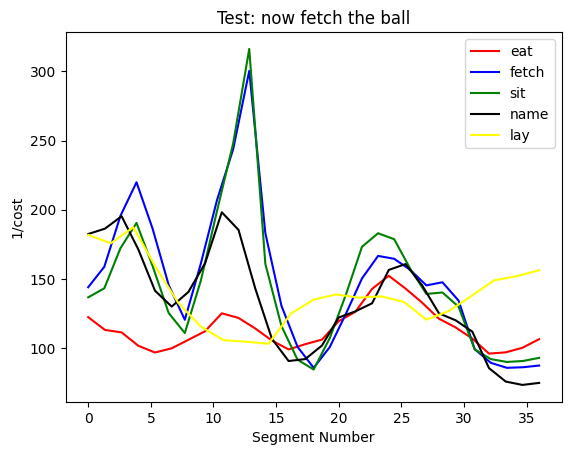

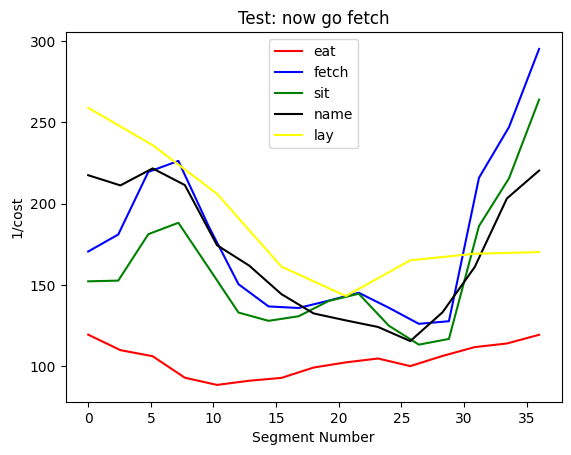

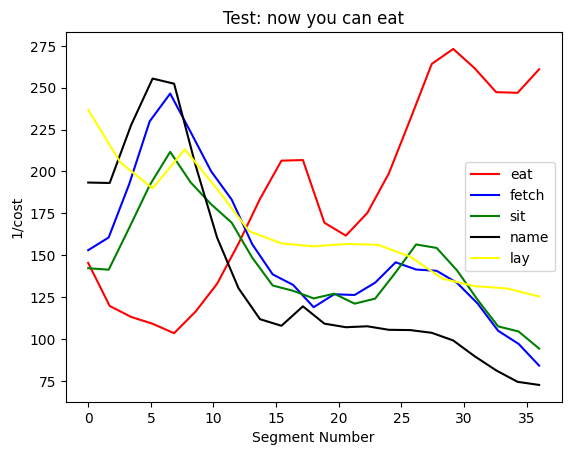

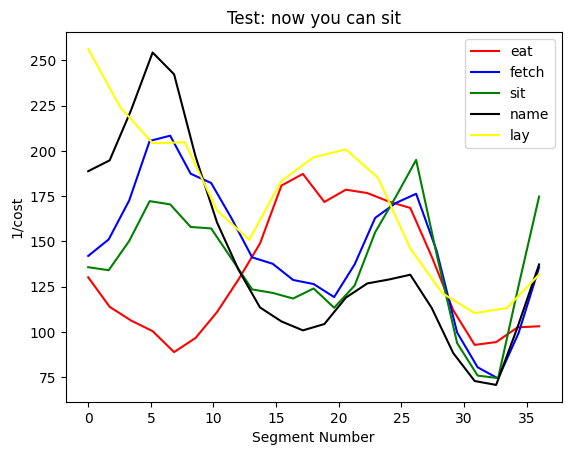

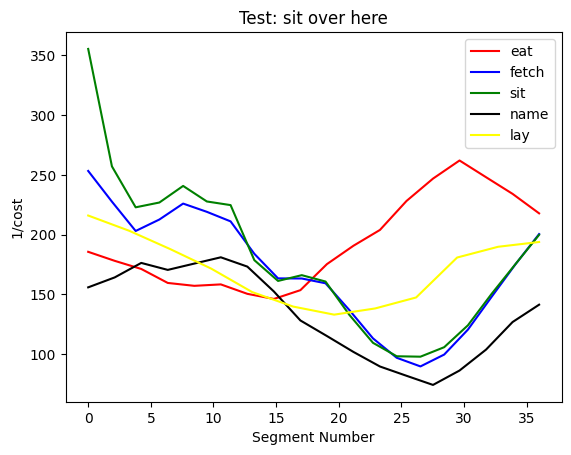

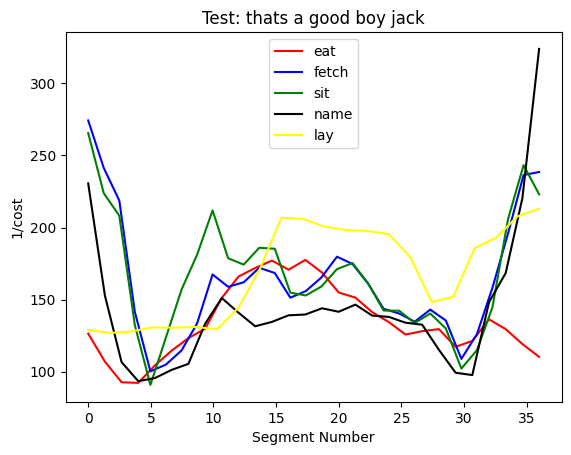

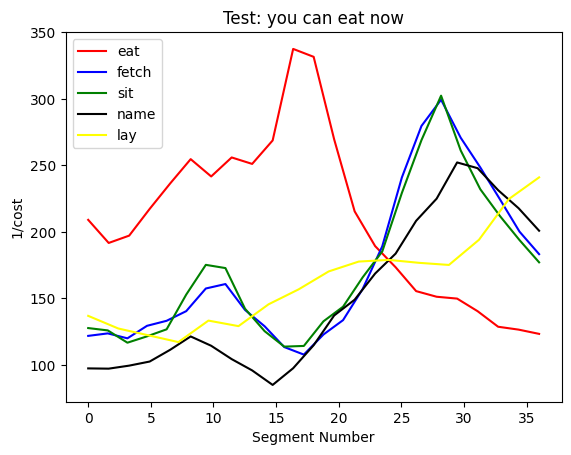

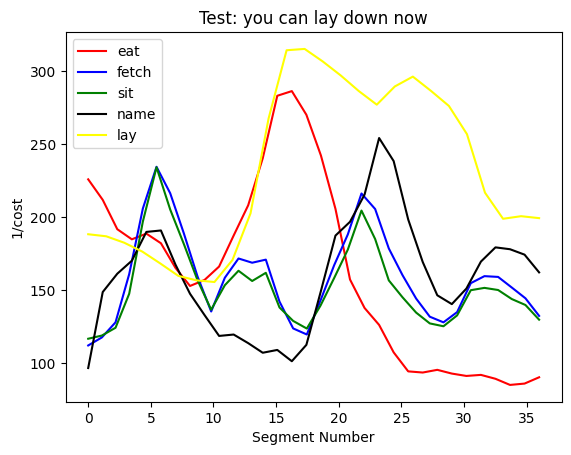

In [25]:
colors=['red', 'blue', 'green', 'black', 'yellow']
num=1
count=0
for test in tests:
    f=plt.figure(num)
    for test_label, train_label, cost, axis in zip(data_avg['test'], data_avg['train'], data_avg['cost'], data_avg['axis']):
        if test_label == test:
            if train_label == train[0]:
                j=0
            elif train_label == train[1]:
                j=1
            elif train_label == train[2]:
                j=2
            elif train_label == train[3]:
                j=3
            elif train_label == train[4]:
                j=4
            plot_cost=[]
            for i in cost:
                plot_cost.append(1/i)
            plt.plot(axis, plot_cost, color=colors[j], label=train[j])
    plt.title('Test: '+test)
    plt.xlabel('Segment Number')
    plt.ylabel('1/cost')
    plt.legend()
    f.savefig("avg"+str(count)+".png")
    f.show()
    num+=1
    count+=1

(0.0013, 0.0102)

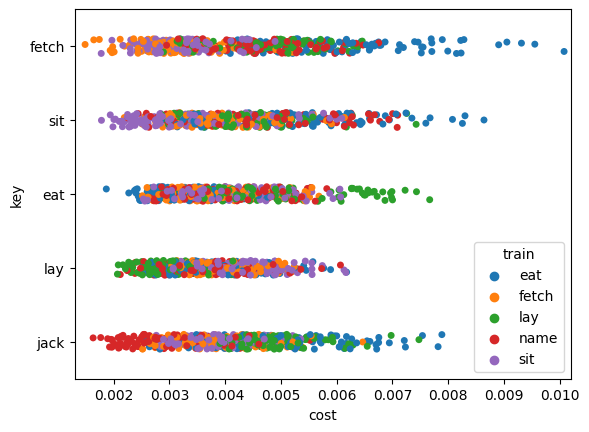

In [26]:
df = pd.DataFrame.from_dict(all_comp_before)
plt.figure()
sns.stripplot(data = df,
      x='cost', y='key', 
      hue = 'train', jitter=True)
plt.xlim(0.0013, 0.0102)

(0.0013, 0.0102)

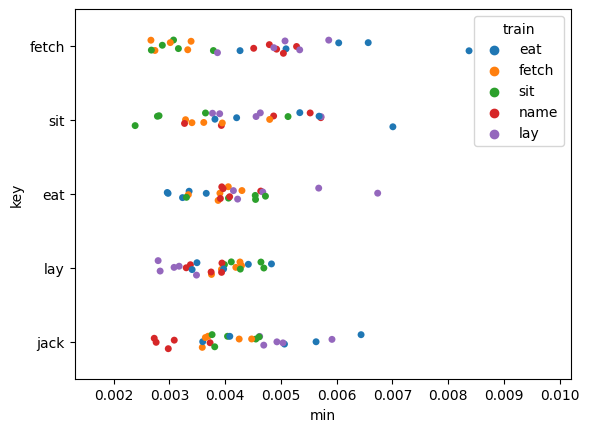

In [27]:
df = pd.DataFrame.from_dict(all_comp)
plt.figure()
sns.stripplot(data = df,
      x='min', y='key', 
      hue = 'train', jitter=True)
plt.xlim(0.0013, 0.0102)

<AxesSubplot:xlabel='cost', ylabel='key'>

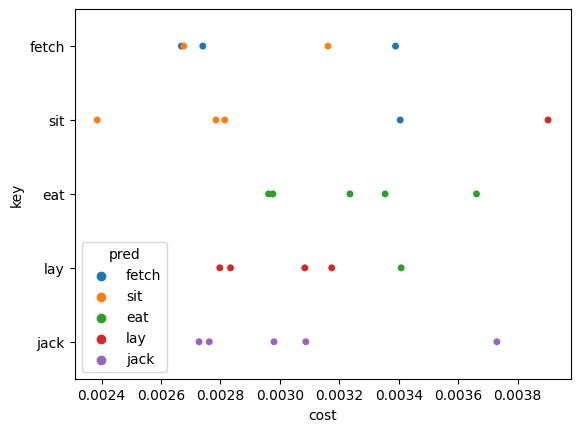

In [28]:
df = pd.DataFrame.from_dict(all_pred)
plt.figure()
sns.stripplot(data = df,
      x='cost', y='key', 
      hue = 'pred', jitter=False)

In [29]:
costs=all_pred['cost']
total=0
for cost in costs:
    total = total+cost
avg_pred_cost = total/float(len(costs))
print(avg_pred_cost)
print(accuracy)

0.0030680702887123296
80.0


<AxesSubplot:xlabel='method'>

<Figure size 640x480 with 0 Axes>

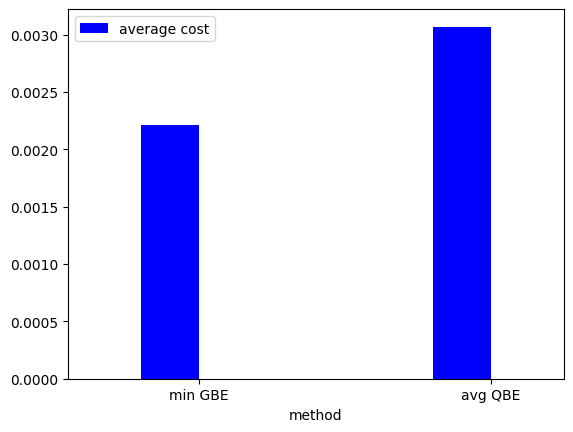

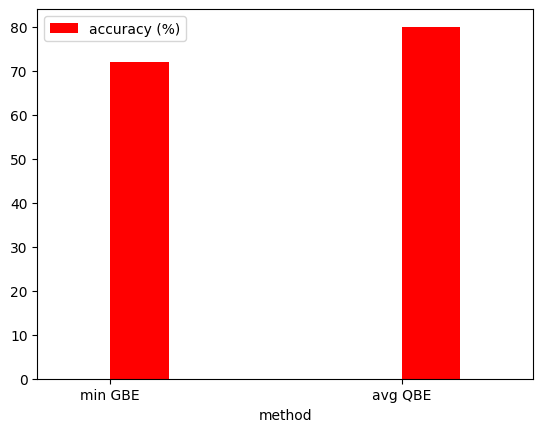

In [30]:
comparison={'average cost': [0.002214, 0.003068], 'accuracy (%)': [72, 80], 'method':['min GBE', 'avg QBE']}
df = pd.DataFrame.from_dict(comparison)
fig = plt.figure()


fig = plt.figure(1)
df.plot.bar(x='method', y='average cost', rot=0, color='blue', position=1, width=0.2)
fig = plt.figure(2)
df.plot.bar(x='method', y='accuracy (%)', rot=0, color='red', position=0, width=0.2)
